In [ ]:
# based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import matplotlib
import tqdm.auto as tqdm

import os
from PIL import Image
from sklearn.metrics import accuracy_score
import torchvision
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset, SubsetRandomSampler
import time
import copy
from sklearn.model_selection import KFold

plt.style.use('seaborn')

In [2]:
import DiagnosisFunctions.tools as DiagTools
train_split, val_split, test_split, _ = DiagTools.get_splits()

In [3]:
class DiagnosisDataset(Dataset):
    '''
    Define our dataset
    '''
    def __init__(self, path, target, transforms = torch.nn.Sequential()):
        #Input:
        # path:   path to the images.
        # target: target diagnosis.
        
        assert len(path) == len(target), 'path and target should be the same length.'
        
        self.path   = path
        self.target = target
        self.transforms = transforms
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        path   = self.path[idx]
        target = self.target[idx]
        
        #Load the image
        im = Image.open(path)
        im = np.array(im) #4th channel is alpha.
        im = torch.tensor(im, dtype=torch.float32).permute(2,0,1) / 255.
        
        if self.transforms is not None:
            im = self.transforms(im)
            
        return im, target, path

In [4]:
train_transforms = nn.Sequential(transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]))

val_transforms = nn.Sequential(transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]))

train_dataset = DiagnosisDataset(*train_split, transforms=train_transforms)
val_dataset = DiagnosisDataset(*val_split, transforms=val_transforms)
test_dataset = DiagnosisDataset(*test_split)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers=4)  
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=False, num_workers=4)  
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False)

datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
def train_and_eval(phase, model, optimizer, criterion, scheduler, dataloaders, datasets):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0.0

    for inputs, labels, _ in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    if phase == 'train':
        scheduler.step()

    epoch_loss = running_loss / len(datasets[phase])
    epoch_acc = running_corrects.double() / len(datasets[phase])

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc
    

In [6]:
k = 5
splits = KFold(n_splits=k)
num_epochs = 20
since = time.time()

dataset = ConcatDataset([train_dataset, val_dataset])
acc = {'train': [[] for _ in range(k)], 'val': [[] for _ in range(k)]}
loss = {'train': [[] for _ in range(k)], 'val': [[] for _ in range(k)]}

for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold + 1))
    
    # define train and val set inside fold to avoid data leakage
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    train_loader = DataLoader(dataset, batch_size=64, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=64, sampler=val_sampler)

    # here we can easily try out other pretrained CNNs
    model = torchvision.models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Sequential(nn.Dropout(0.4),
                                        nn.Linear(num_features, 6))
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            epoch_loss, epoch_acc = train_and_eval(phase, model, optimizer, criterion, scheduler, dataloaders, datasets)
            loss[phase][fold].append(epoch_loss)
            acc[phase][fold].append(epoch_acc.item())
        print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Fold 1
Epoch 0/9
----------
train Loss: 1.8175 Acc: 0.1577
val Loss: 1.8030 Acc: 0.1471

Epoch 1/9
----------
train Loss: 1.7684 Acc: 0.2429
val Loss: 1.7473 Acc: 0.2647

Epoch 2/9
----------
train Loss: 1.7228 Acc: 0.2871
val Loss: 1.6857 Acc: 0.3235

Epoch 3/9
----------
train Loss: 1.6587 Acc: 0.3533
val Loss: 1.6382 Acc: 0.3824

Epoch 4/9
----------
train Loss: 1.6005 Acc: 0.4164
val Loss: 1.5776 Acc: 0.4118

Epoch 5/9
----------
train Loss: 1.5682 Acc: 0.4069
val Loss: 1.5223 Acc: 0.5147

Epoch 6/9
----------
train Loss: 1.4998 Acc: 0.5016
val Loss: 1.4640 Acc: 0.5882

Epoch 7/9
----------
train Loss: 1.4818 Acc: 0.4984
val Loss: 1.4577 Acc: 0.5882

Epoch 8/9
----------
train Loss: 1.4829 Acc: 0.5047
val Loss: 1.4575 Acc: 0.5735

Epoch 9/9
----------
train Loss: 1.4714 Acc: 0.4732
val Loss: 1.4560 Acc: 0.5735

Fold 2
Epoch 0/9
----------
train Loss: 1.8399 Acc: 0.1420
val Loss: 1.8526 Acc: 0.1176

Epoch 1/9
----------
train Loss: 1.7960 Acc: 0.2114
val Loss: 1.7721 Acc: 0.2500

Ep

KeyboardInterrupt: 

In [ ]:
pickle.dump((acc,loss), open('acc_loss.p', 'wb'))

In [13]:
import pickle

acc = pickle.load(open('acc_loss.p', 'rb'))[0]
loss = pickle.load(open('acc_loss.p', 'rb'))[1]

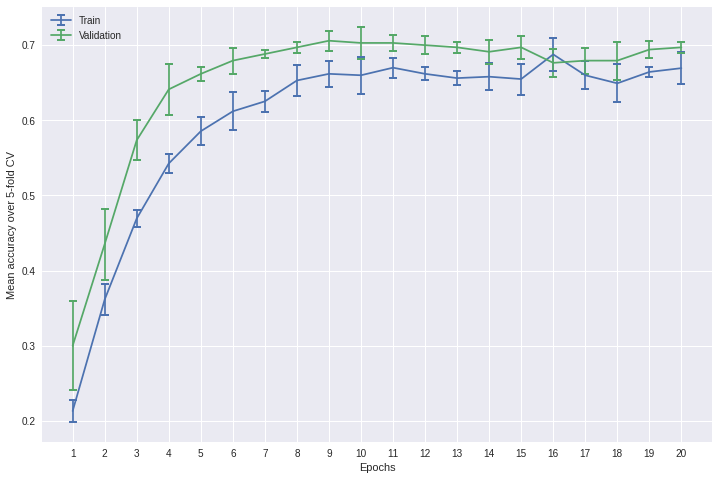

In [48]:
plt.figure(figsize=(12,8))
plt.errorbar(range(20), np.array(acc['train']).T.mean(axis=1), yerr=np.array(acc['train']).T.std(axis=1), capsize=4, capthick=2, label='Train')
plt.errorbar(range(20), np.array(acc['val']).T.mean(axis=1), yerr=np.array(acc['val']).T.std(axis=1), capsize=4, capthick=2, label='Validation')
plt.legend()
plt.xticks(range(0,20), range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Mean accuracy over 5-fold CV')
plt.show()

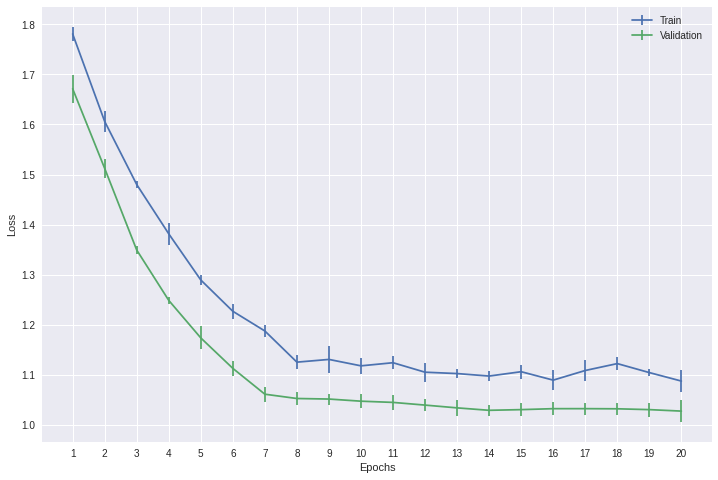

In [39]:
plt.figure(figsize=(12,8))
plt.errorbar(range(20), np.array(loss['train']).T.mean(axis=1), yerr=np.array(loss['train']).T.std(axis=1), label='Train')
plt.errorbar(range(20), np.array(loss['val']).T.mean(axis=1), yerr=np.array(loss['val']).T.std(axis=1), label='Validation')
plt.legend()
plt.xticks(range(0, 20), range(1,21))
plt.xlabel('Epochs')
plt.ylabel('Mean loss over 5-fold CV')
plt.show()